In [7]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
import requests
from PIL import Image

In [9]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="flower_photos.tgz",
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

228813984/228813984 [==============================] - 16s 0us/step


In [11]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl, os.path.basename(t))):
      if not os.path.exists(os.path.join(base_dir, 'train', cl)):
        os.makedirs(os.path.join(base_dir, 'train', cl))
      shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl, os.path.basename(v))):
      if not os.path.exists(os.path.join(base_dir, 'val', cl)):
        os.makedirs(os.path.join(base_dir, 'val', cl))
      shutil.move(v, os.path.join(base_dir, 'val', cl))

roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images


In [13]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

batch_size = 100
IMG_SHAPE = 150

image_gen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(
    train_dir,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    batch_size=batch_size,
    shuffle=True
)

Found 2935 images belonging to 5 classes.


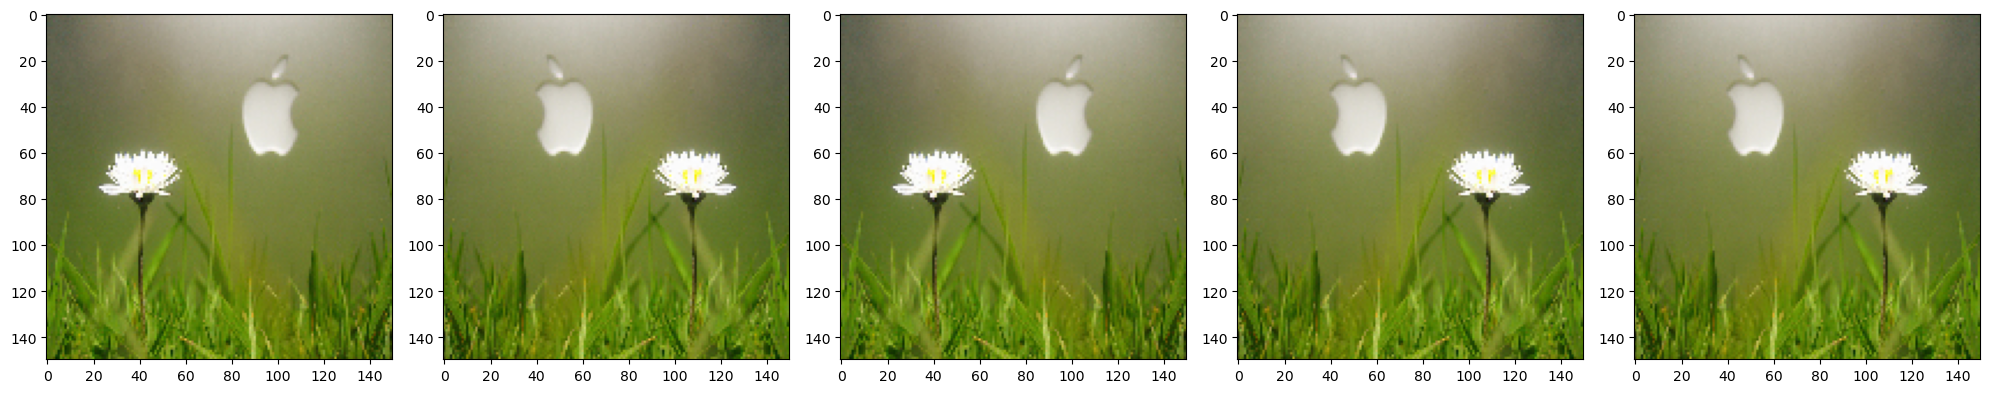

In [15]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [17]:
image_gen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=45
)

train_data_gen = image_gen.flow_from_directory(
                train_dir,
                target_size=(IMG_SHAPE, IMG_SHAPE),
                batch_size=batch_size,
                shuffle=True
)

Found 2935 images belonging to 5 classes.


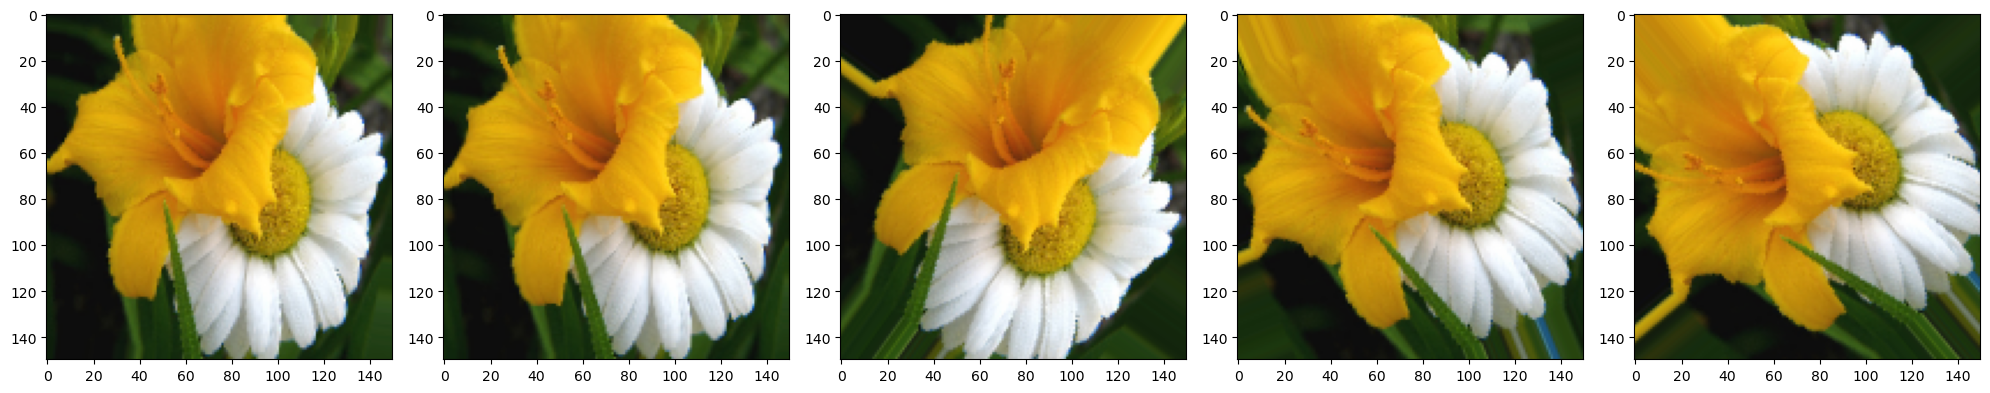

In [19]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Found 2935 images belonging to 5 classes.


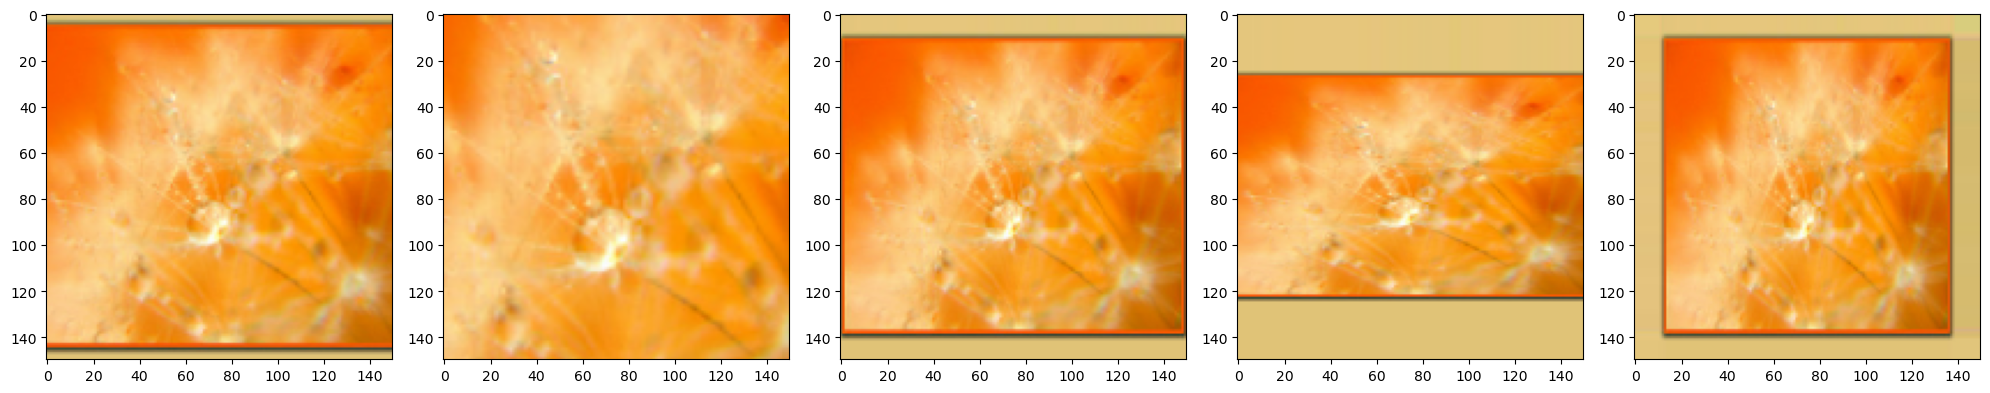

In [21]:
image_gen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.5
)

train_data_gen = image_gen.flow_from_directory(train_dir, target_size=(IMG_SHAPE, IMG_SHAPE),
                                               batch_size=batch_size, shuffle=True)

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Found 2935 images belonging to 5 classes.


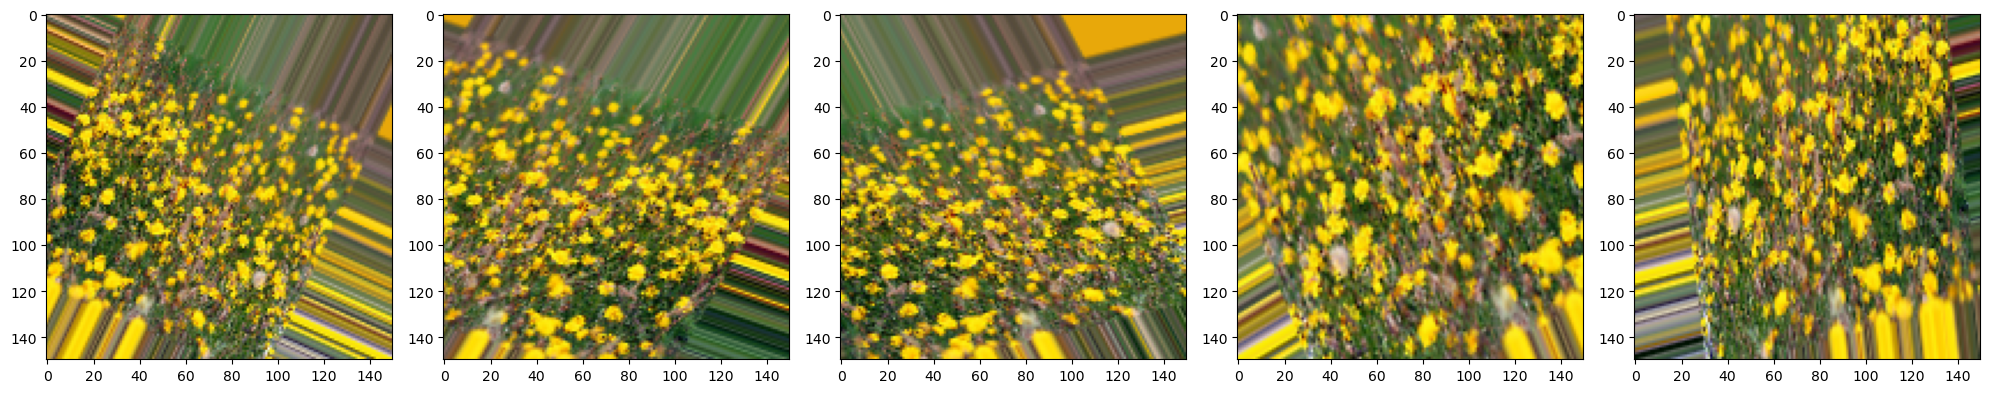

In [23]:
image_gen_train = ImageDataGenerator(
            rescale=1./255,
            rotation_range=45,
            horizontal_flip=True,
            width_shift_range=0.15,
            height_shift_range=0.15,
            zoom_range=0.5
)


train_data_gen = image_gen_train.flow_from_directory(
                train_dir, batch_size=batch_size,
                target_size=(IMG_SHAPE,IMG_SHAPE), shuffle=True,
                class_mode='sparse'
)

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [25]:
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(val_dir, target_size=(IMG_SHAPE,IMG_SHAPE),
                                                 batch_size=batch_size,class_mode='sparse')

Found 735 images belonging to 5 classes.


In [27]:
model = Sequential([
    Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
    MaxPool2D(2,2),
    Dropout(0.2),

    Conv2D(32, (3,3), padding='same',activation='relu'),
    MaxPool2D(2,2),
    Dropout(0.2),

    Conv2D(64, (3,3), padding='same',activation='relu'),
    MaxPool2D(2,2),
    Dropout(0.2),

    Flatten(),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 75, 75, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 37, 37, 32)        0

In [29]:
epochs = 80

history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)

model.save('modelo_flores.h5')

Epoch 1/80
30/30 [==============================] - 48s 2s/step - loss: 1.5839 - accuracy: 0.2770 - val_loss: 1.4959 - val_accuracy: 0.3551
Epoch 2/80
30/30 [==============================] - 29s 950ms/step - loss: 1.4733 - accuracy: 0.3448 - val_loss: 1.4599 - val_accuracy: 0.3401
Epoch 3/80
30/30 [==============================] - 28s 927ms/step - loss: 1.3886 - accuracy: 0.4041 - val_loss: 1.4174 - val_accuracy: 0.4177
Epoch 4/80
30/30 [==============================] - 28s 937ms/step - loss: 1.2961 - accuracy: 0.4344 - val_loss: 1.3279 - val_accuracy: 0.4408
Epoch 5/80
30/30 [==============================] - 28s 929ms/step - loss: 1.2266 - accuracy: 0.4620 - val_loss: 1.2841 - val_accuracy: 0.4626
Epoch 6/80
30/30 [==============================] - 28s 917ms/step - loss: 1.2043 - accuracy: 0.4804 - val_loss: 1.2643 - val_accuracy: 0.4558
Epoch 7/80
30/30 [==============================] - 28s 927ms/step - loss: 1.1713 - accuracy: 0.5049 - val_loss: 1.2394 - val_accuracy: 0.4544
Ep

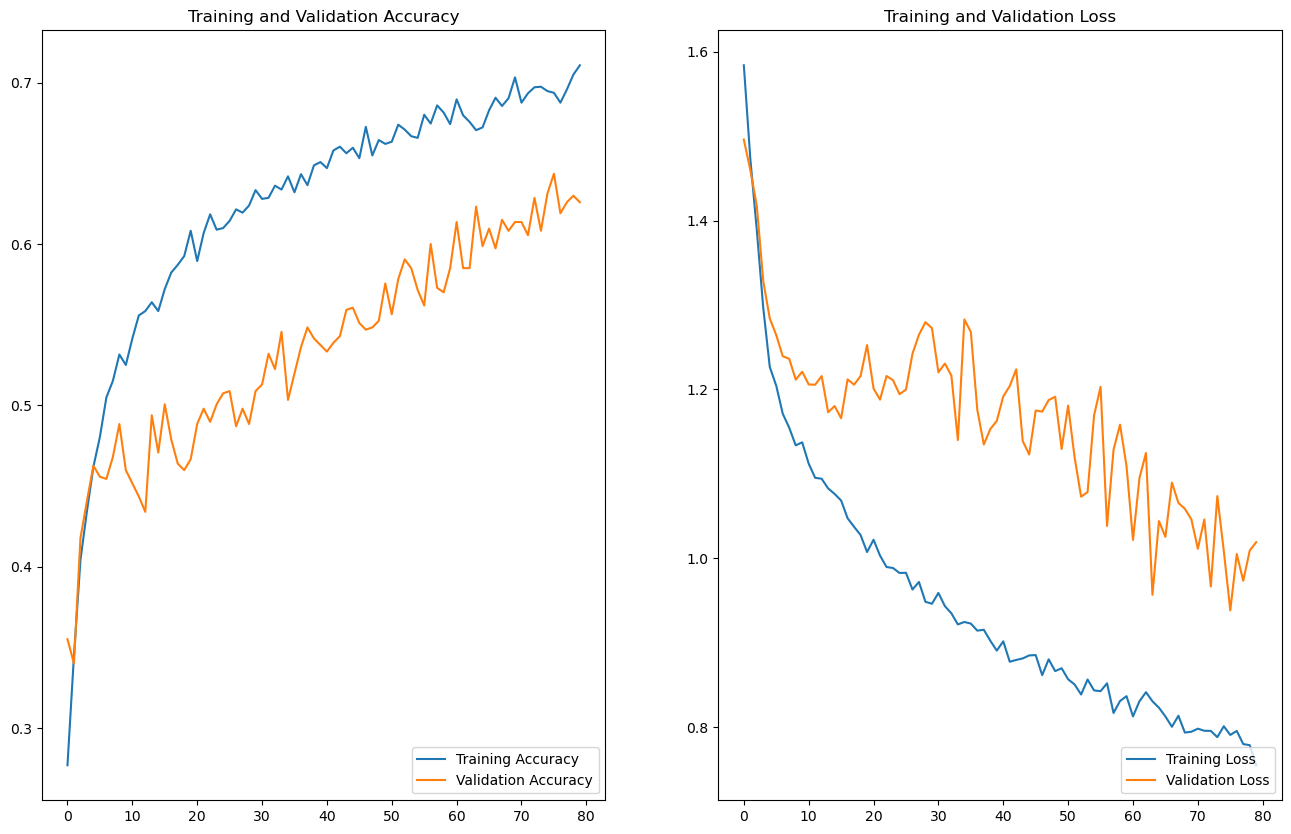

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(val_acc))

plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc[:len(val_acc)], label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss[:len(val_acc)], label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

plt.show()

Imagem baixada e salva como 'tulipa.jpg' em 'imagens'


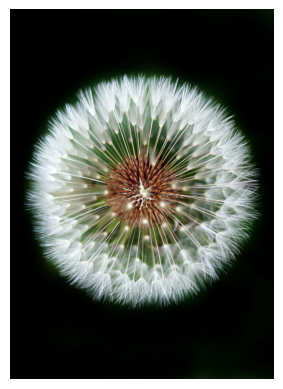

1/1 [==============================] - 0s 78ms/step
Imagem é 'daisy, indice previsto: 1


In [91]:
def baixar_e_renomear_imagem(url_imagem, nome_arquivo, pasta_destino):
  os.makedirs(pasta_destino, exist_ok=True)
  resposta = requests.get(url_imagem, stream=True)
  resposta.raise_for_status()
  caminho_arquivo = os.path.join(pasta_destino, nome_arquivo)
  with open(caminho_arquivo, 'wb') as arquivo:
    for pedaco in resposta.iter_content(chunk_size=8192):
      arquivo.write(pedaco)

  print(f"Imagem baixada e salva como '{nome_arquivo}' em '{pasta_destino}'")
  img = plt.imread(caminho_arquivo)
  plt.imshow(img)
  plt.axis('off')
  plt.show()

# Exemplo de uso
url_imagem = "https://images.unsplash.com/photo-1520548636995-ab410381561e?fm=jpg&q=60&w=3000&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8MjB8fGRhbmRlbGlvbnxlbnwwfHwwfHx8MA%3D%3D"
nome_arquivo = "tulipa.jpg"
pasta_destino = "imagens"

baixar_e_renomear_imagem(url_imagem, nome_arquivo, pasta_destino)

model = tf.keras.models.load_model('modelo_flores.h5')
img_path = os.path.join(pasta_destino, nome_arquivo)

def pre_processamento_imagem(caminho_imagem):
  """Carrega e pré-processa uma imagem para o modelo."""
  imagem = Image.open(caminho_imagem)
  imagem = imagem.resize((150, 150))  # Ajusta o tamanho para o modelo original (150, 150)
  imagem = np.array(imagem) / 255.0  # Normaliza os valores dos pixels
  imagem = imagem.reshape((1, 150, 150, 3))  # Adiciona uma dimensão para o batch e usa o tamanho correto
  return imagem

imagem = pre_processamento_imagem(img_path)

previsao = model.predict(imagem)
indice_previsto = np.argmax(previsao)
rotulo_previsto = classes[indice_previsto]

# classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']
print(f"Imagem é '{rotulo_previsto}, indice previsto: {indice_previsto}")